# Master thesis - Datacentric aproach to time series forecasting 

Authors:
- Berling Gustav - gusbe498@student.liu.se
- Janzén Albin - albja295@student.liu.se

Import libraries, data and set global parameters

In [126]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython
import IPython.display
import shap
from tqdm.notebook import tqdm
from matplotlib.patches import Rectangle

# Set random seed for reproducibility
tf.random.set_seed(1234)
tf.keras.utils.set_random_seed(1234)

# Load the dataset from CSV file
og_df = pd.read_csv('data/Structured/all_data.csv')

#Plot colors
colors = ['#003f5c', '#58508d', '#bc5090', '#ff6361', '#ffa600']

Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.


Remove empty data and change order of columns

In [2]:
#Drop all empty columns
df = og_df.dropna(axis=1, how='all')
df.drop(['Summa gas/Diesel'], axis=1, inplace=True)

#Fill missing values with the previous value
df = df.fillna(method='ffill')
#Fill missing values with the next value
df = df.fillna(method='bfill')
#Remove collumns with only one value
for e in df.columns:
    if df[e].nunique() == 1:
        df = df.drop(e, axis=1)

#Change index of target variable  
first_column = df.pop('SE1')
df.insert(1, 'SE1', first_column)

#Set date for end of test data
test_end = df[df['Date'] == '2018-01-01 23:00:00'].index.values[0]

#Remove dates from dataframe
dates = df.pop('Date')

#Save number of features
n_features = df.shape[1]
print(n_features)

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
df[df.columns] = scaler.fit_transform(df[df.columns])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


(202878, 470)
470


Plot target variable

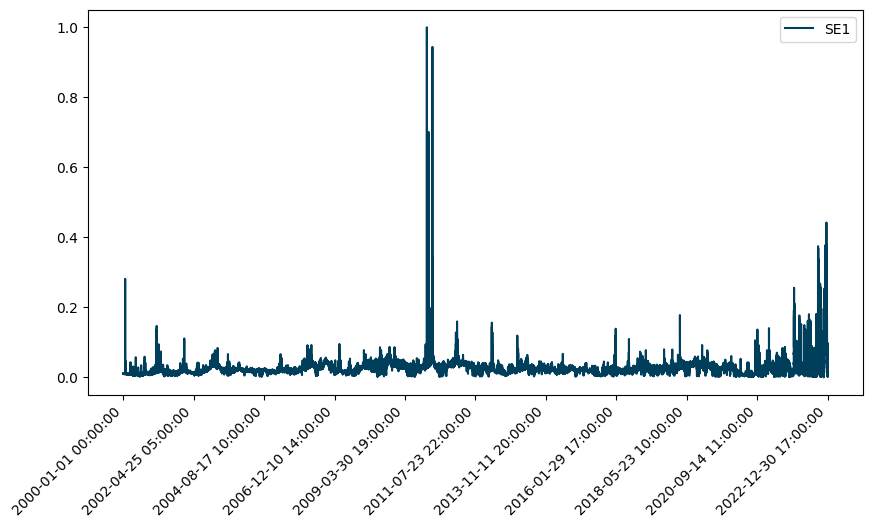

In [161]:
y = df['SE1']
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(y, color=colors[0], label='SE1')
ax.legend()
ax.set_xticks(np.arange(0, len(dates), len(dates)//10))
ax.set_xticklabels(dates[::len(dates)//10], rotation=45, ha='right')
plt.show()

Divide train, validation and test set

In [4]:

# Split the dataset into training and testing sets
test_size = int(len(df) * 0.05)
val_size = int(len(df) * 0.1)
val_end = test_end - test_size

train_df = df[:val_end-val_size]
train_dates = dates[:val_end-val_size]

val_df = df[val_end-val_size:val_end]
val_dates = dates[val_end-val_size:val_end]

test_df = df[test_end-test_size:test_end]
test_dates = dates[test_end-test_size:test_end]

train_df = pd.concat([train_df, df[test_end:]])
train_dates = pd.concat([train_dates, dates[test_end:]])

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(172448, 470)
(20287, 470)
(10143, 470)


Select target variable and lag the data for forecasting

In [5]:

lag = 1

train_df = train_df.to_numpy()
# print(train_df.shape)
val_df = val_df.to_numpy()
test_df = test_df.to_numpy()
X_train = np.reshape(train_df, (train_df.shape[0], 1, train_df.shape[1]))
y_train = train_df[:,0]

#shift the data
X_train = X_train[:-lag]
train_dates = train_dates[:-lag]
y_train = y_train[lag:]

X_val = np.reshape(val_df, (val_df.shape[0], 1, val_df.shape[1]))
y_val = val_df[:,0]

#shift the data
X_val = X_val[:-lag]
val_dates = val_dates[:-lag]
y_val = y_val[lag:]

X_test = np.reshape(test_df, (test_df.shape[0], 1, test_df.shape[1]))
y_test = test_df[:,0]

#shift the data
X_test = X_test[:-lag]
test_dates = test_dates[:-lag]
y_test = y_test[lag:]

Adapt the data to the batching

In [6]:
batch_size = 128
print(X_train.shape)
# Calculate the number of samples that are evenly divisible by batch_size
num_samples_train = X_train.shape[0] // batch_size * batch_size
num_samples_val = X_val.shape[0] // batch_size * batch_size
num_samples_test = X_test.shape[0] // batch_size * batch_size

# Reshape the input data to have a shape that is evenly divisible by batch_size
X_train = X_train[:num_samples_train]
y_train = y_train[:num_samples_train]
train_dates = train_dates[:num_samples_train]

X_val = X_val[:num_samples_val]
y_val = y_val[:num_samples_val]
val_dates = val_dates[:num_samples_val]

X_test = X_test[:num_samples_test]
y_test = y_test[:num_samples_test]
test_dates = test_dates[:num_samples_test]

# Verify that the new shape is evenly divisible by batch_size
assert X_train.shape[0] % batch_size == 0
assert X_val.shape[0] % batch_size == 0
assert X_test.shape[0] % batch_size == 0

(172447, 1, 470)


Plot the data split (only target variable is shown but is done on the whole dataset)

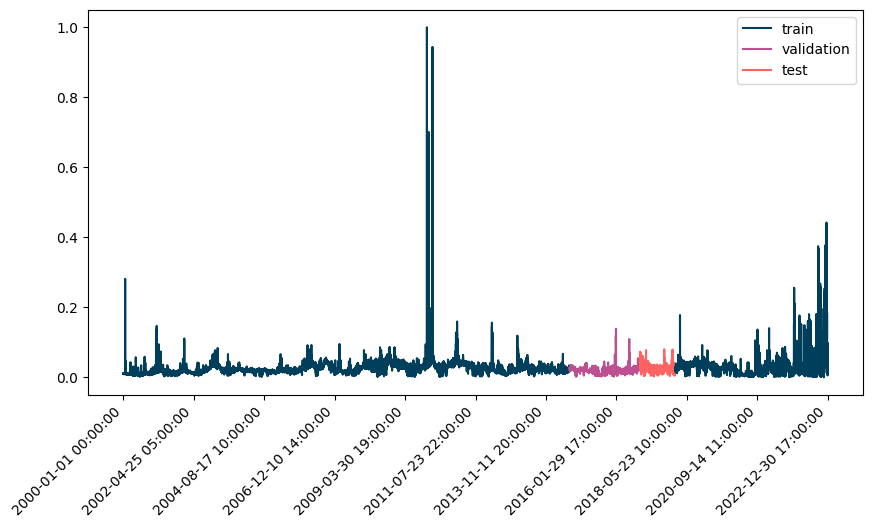

In [159]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(np.arange(0,val_end-val_size), y_train[0:val_end-val_size], color=colors[0], label='train')
ax.plot(np.arange(val_end-y_val.shape[0], val_end), y_val, color=colors[2], label='validation')
ax.plot(np.arange(test_end-y_test.shape[0], test_end), y_test, color=colors[3], label='test')
ax.plot(np.arange(test_end,(test_end + y_train[val_end-val_size:].shape[0])), y_train[val_end-val_size:], color=colors[0])
ax.set_xticks(np.arange(0, len(dates), len(dates)//10))
ax.set_xticklabels(dates[::len(dates)//10], rotation=45, ha='right')
ax.legend()
plt.show()

Create the LSTM model

In [8]:
# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, batch_input_shape=(batch_size, None, n_features), stateful=True),
    tf.keras.layers.Dense(1)
])

Class for plotting the learning process, used as a callback for the compile function of the model

In [151]:

class PlotLearning(tf.keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        IPython.display.clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric, color=colors[0])
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric, color=colors[3])
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

Compile and fit the model: train the model

In [10]:
def compile_and_fit(model, X_train, y_train, patience=10):
  tf.keras.backend.clear_session()
  model.reset_states()
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    restore_best_weights=True,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])
  model.build(X_train.shape)
  print(model.summary())
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=batch_size, verbose=1,
                      callbacks=[early_stopping,PlotLearning()])
  return history

# Data Analysis functions

feature_cutoff: Plot and calculate data cutoff based on mae impact

In [149]:
def feature_cutoff(df, baseline_mae, n_cols, iteration, cutoff = 0, prime = 0):
    df = pd.read_csv(iteration + '_feature_importance.csv', header=None, names=['feature','mae'])
    df = df.sort_values('mae')

    plt.figure(figsize=(10,n_cols//5))
    print(n_cols)
    print(df.mae.shape)
    plt.barh(np.arange(n_cols + 1),df.mae, color=colors[0])
    plt.yticks(np.arange(n_cols + 1),df.feature.values)
    plt.title('LSTM Feature Importance',size=16)
    plt.ylim((-1,n_cols + 1))

    plt.plot([baseline_mae,baseline_mae],[-1,n_cols + 1], '--', color=colors[4],
                label=f'Baseline \nMAE={baseline_mae:.4f}')
    a_set_columns = [] 
    b_set_columns = []
    prime_set_columns = []

    df = df[df.feature != 'Baseline']

    if cutoff != 0:
        if cutoff == 1:
            cutoff = np.std(df[df['mae'] < baseline_mae]).mae
        a_set_columns = df[df['mae'] >= baseline_mae - cutoff].feature
        b_set_columns = df[df['mae'] < baseline_mae - cutoff].feature
        plt.plot([baseline_mae-cutoff,baseline_mae-cutoff],[-1,n_cols+1], '--', color=colors[1],
                    label=f'Cutoff threshold\nMAE={baseline_mae-cutoff:.4f}')

    if prime != 0:
        if prime == 1:
            prime = np.std(df[df['mae'] > baseline_mae]).mae
        prime_set_columns = df[df['mae'] > baseline_mae + prime].feature
        plt.plot([baseline_mae+prime,baseline_mae+prime],[-1,n_cols+1], '--', color=colors[3],
                    label=f'Cutoff threshold\nMAE={baseline_mae+prime:.4f}')

    plt.ylabel('Feature',size=14)
    plt.legend()
    plt.show()

    return a_set_columns, b_set_columns, prime_set_columns

unique_average: Compute the average number of features that has low data uniqueness

In [145]:
def unique_average(data):
    list = []
    for i in range(data.shape[1]):
        list.append(data.iloc[:,i].nunique())
    list = pd.DataFrame(list)
    print('Average amount of unique values per feature:')
    print(np.mean(list))
    print('Average percentage of unique values per feature:')
    print(np.mean(list)/data.shape[0])
    plt.plot(list, color=colors[0], label='Unique values')
    plt.legend()

boxplot: Create a boxplot

In [144]:
def boxplot(data, columns):
    fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(9, columns.shape[0]//6))

    meds = data.median()
    meds.sort_values(ascending=False, inplace=True)
    data = data[meds.index]

    bplot1 = ax1.boxplot(data, vert=False, patch_artist=True, labels=columns)  

    plt.setp(bplot1["boxes"], facecolor=colors[0])
    plt.setp(bplot1["whiskers"], color=colors[2])
    plt.setp(bplot1["fliers"], markeredgecolor=colors[4])
    plt.show()

feature_importance: Calculate feature importance

In [14]:
import os
def feature_importance(model, X, y, df, batch_size, iteration):
    n_permutations = 5
    COLS = list(df.columns[1:])
    n_cols = len(COLS)
    print('Computing LSTM feature importance...')

    preds = model.predict(X, verbose=0, batch_size=batch_size).squeeze() 
    baseline_mae = np.mean(np.abs( preds-y ))
    print(baseline_mae)
    if os.path.exists(iteration + '_feature_importance.csv'):
        os.remove(iteration + '_feature_importance.csv')
    fi_df = pd.DataFrame(['Baseline', baseline_mae]).T
    fi_df.to_csv(iteration + '_feature_importance.csv', index=False, header=False)
    for k in range(n_cols):
        save_col = X[:,:,k].copy()
        if k % 50 == 0:
            print(k)
        mae_list = np.zeros(n_permutations)
        
        for i in range(n_permutations):
            X[:,:,k] = np.random.permutation(X[:,:,k])
            preds = model.predict(X, verbose=0, batch_size=batch_size).squeeze() 
            mae_list[i] = np.mean(np.abs( preds-y ))
         
        mae = np.mean(mae_list) 
        fi_df = pd.DataFrame([COLS[k], mae]).T
        fi_df.to_csv(iteration + '_feature_importance.csv', mode='a', index=False, header=False)
        X[:,:,k] = save_col
    
    return baseline_mae, n_cols

time_slice_mae_plot: plot the mae over batch time slices

In [129]:
def time_slice_mae_plot(model, X, y, batch_size, dates):
    assert X.shape[0] % batch_size == 0
    n_batches = int(X.shape[0] / batch_size)
    print(n_batches)
    time_slice_mae = pd.DataFrame(np.zeros(n_batches), columns=['mae'])
    for i in range(n_batches):
        data = X[i*batch_size:(i+1)*batch_size,:,:]
        preds = model.predict(data, verbose=0, batch_size=batch_size).squeeze() 
        time_slice_mae.iloc[i] = np.mean(np.abs(preds-y[i*batch_size:(i+1)*batch_size]))
    time_slice_mae.reset_index(drop=True, inplace=True)

    pred = model.predict(X, verbose=0, batch_size=batch_size).squeeze()

    x_index = np.arange(0, y.shape[0], batch_size)

    fig,(ax, ax2)  = plt.subplots(1,2, figsize=(20, 5))
    
    ax.set_ylabel("SE1",
                fontsize=14, color='grey')

    ax.fill_between(
        np.arange(0,len(pred)), pred, y, where=(pred > y), 
        interpolate=True, color=colors[2], alpha=1, 
        label="Larger forecast", zorder=2
    )
    ax.fill_between(
        np.arange(0,len(pred)), pred, y, where=(pred < y), 
        interpolate=True, color=colors[0], alpha=1, 
        label="Lower forecast", zorder=2
    )
    
    ax.set_xticks(np.arange(0, len(dates), len(dates)//10))
    ax.set_xticklabels(dates[::len(dates)//10], rotation=45, ha='right')
    ax.legend()
    ax2.plot(x_index, time_slice_mae, color=colors[0], label='Slice MAE')
    std_dev = np.std(time_slice_mae).mae + np.mean(time_slice_mae).mae
    ax2.axhline(y=std_dev, color=colors[4])
    ax2.set_xticks(np.arange(0, len(dates), len(dates)//10))
    ax2.set_xticklabels(dates[::len(dates)//10], rotation=45, ha='right')
    ax2.legend()
    plt.show()

    result = time_slice_mae['mae'] > std_dev
    return result, pred


getSlices: get the interesting slices to analyse

In [120]:
def getSlices(X, y, batch_slices, batch_size, preds, dates):
    indices = []
    n_batches = int(X.shape[0] / batch_size)
    for i in range(n_batches):
            if batch_slices[i]:
                    indices.append({'from': i*batch_size, 'to': i*batch_size+batch_size})
    slices = []

    from_index = indices[0]['from']
    to_index = indices[0]['to']
    last_loop_in_range = False

    for i in range(len(indices)-1):
        if indices[i+1]['from'] - indices[i]['to'] < 720:
            to_index = indices[i+1]['to']
            last_loop_in_range = True
        else:
            slices.append({'from': from_index, 'to': to_index})
            from_index = indices[i+1]['from']
            to_index = indices[i+1]['to']
            last_loop_in_range = False

    if last_loop_in_range:
        slices.append({'from': from_index, 'to': to_index})

    fig, ax = plt.subplots(figsize=(20, 12))
    for i in slices:
        ax.add_patch(Rectangle((i['from'], 0), i['to'] - i['from']+128, np.max(y), facecolor='#ffa600', alpha=1, zorder=1))
    
    ax.fill_between(
        np.arange(0,len(preds)), preds, y, where=(preds > y), 
        interpolate=True, color="#bc5090", alpha=1, 
        label="Larger forecast", zorder=2
    )
    ax.fill_between(
        np.arange(0,len(preds)), preds, y, where=(preds < y), 
        interpolate=True, color="#003f5c", alpha=1, 
        label="Lower forecast", zorder=2
    )
    ax.set_xticks(np.arange(0, len(dates), len(dates)//10))
    ax.set_xticklabels(dates[::len(dates)//10], rotation=45, ha='right')
    ax.legend()
    
    plt.show()

    return slices

run_analysis_suite: run the data analysis suite based on the above functions

In [17]:
def run_analysis_suite(data, columns):
    print("Data shape: ")
    print(data.shape)
    unique_average(data)
    boxplot(data, columns)

printSliceMae: print the mae of the interesting slices

In [58]:
def printSliceMae(slices, X, y, model, batch_size):
    for i in slices:
        preds = model.predict(X[i['from']:i['to']], batch_size=batch_size, verbose=0)
        print('steps in slice: ', i['to'] - i['from'], '    mae', np.mean(np.abs(preds-y[i['from']:i['to']])))

# Baseline

## Train Baseline

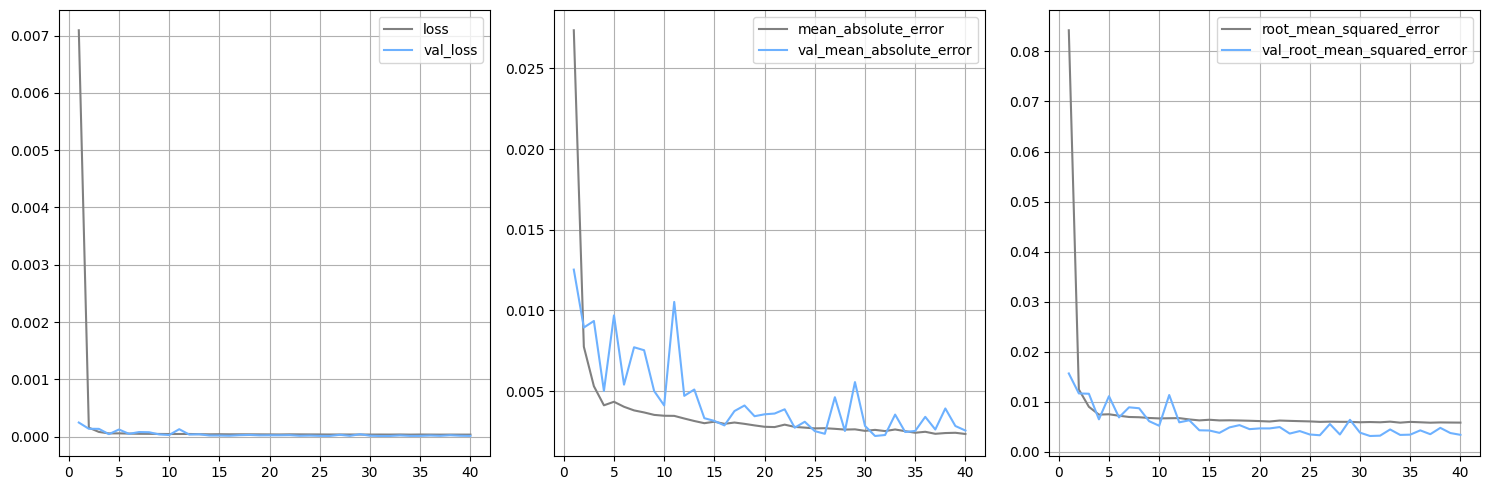

1347/1347 [==============================] - 6s 4ms/step - loss: 3.3917e-05 - mean_absolute_error: 0.0023 - root_mean_squared_error: 0.0058 - val_loss: 1.1441e-05 - val_mean_absolute_error: 0.0026 - val_root_mean_squared_error: 0.0034


In [19]:
history = compile_and_fit(model, X_train, y_train)

## Baseline result/residuals

In [20]:
result = model.predict(X_test, batch_size=batch_size)

79/79 [==============================] - 1s 2ms/step


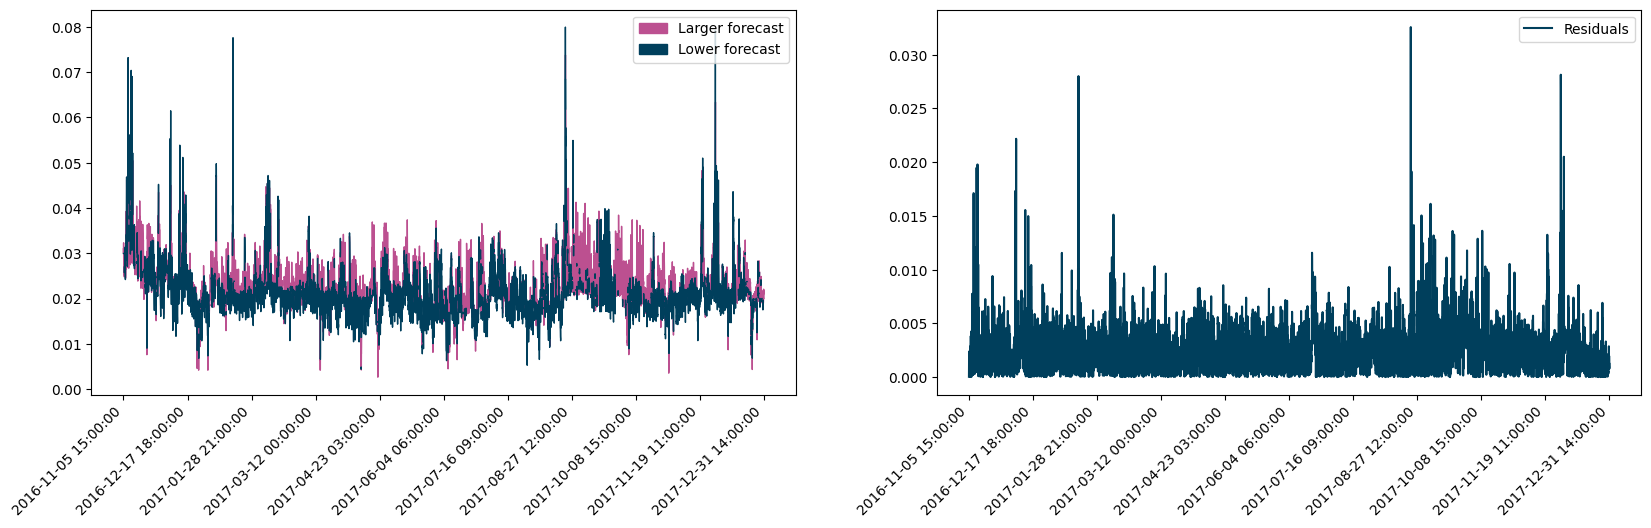

In [157]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
result = result.squeeze()
ax1.fill_between(
    np.arange(0,len(result)), result, y_test, where=(result > y_test), 
    interpolate=True, color=colors[2], alpha=1, 
    label="Larger forecast"
)
ax1.fill_between(
    np.arange(0,len(result)), result, y_test, where=(result < y_test), 
    interpolate=True, color=colors[0], alpha=1, 
    label="Lower forecast"
)
ax1.set_xticks(np.arange(0, len(test_dates), len(test_dates)//10))
ax1.set_xticklabels(test_dates[::len(test_dates)//10], rotation=45, ha='right')
residuals = abs(np.subtract(np.array(result), np.array(y_test)))
# residuals = y_test - result
ax1.legend()
ax2.plot(residuals, label='Residuals', color=colors[0])
ax2.legend()
ax2.set_xticks(np.arange(0, len(test_dates), len(test_dates)//10))
ax2.set_xticklabels(test_dates[::len(test_dates)//10], rotation=45, ha='right')
plt.show()

## Baseline feature importance

In [22]:
baseline_mae, n_cols = feature_importance(model, X_val, y_val, df, batch_size, 'baseline')

Computing LSTM feature importance...
0.0025527222993422167
0
50
100
150
200
250
300
350
400
450


469
(470,)


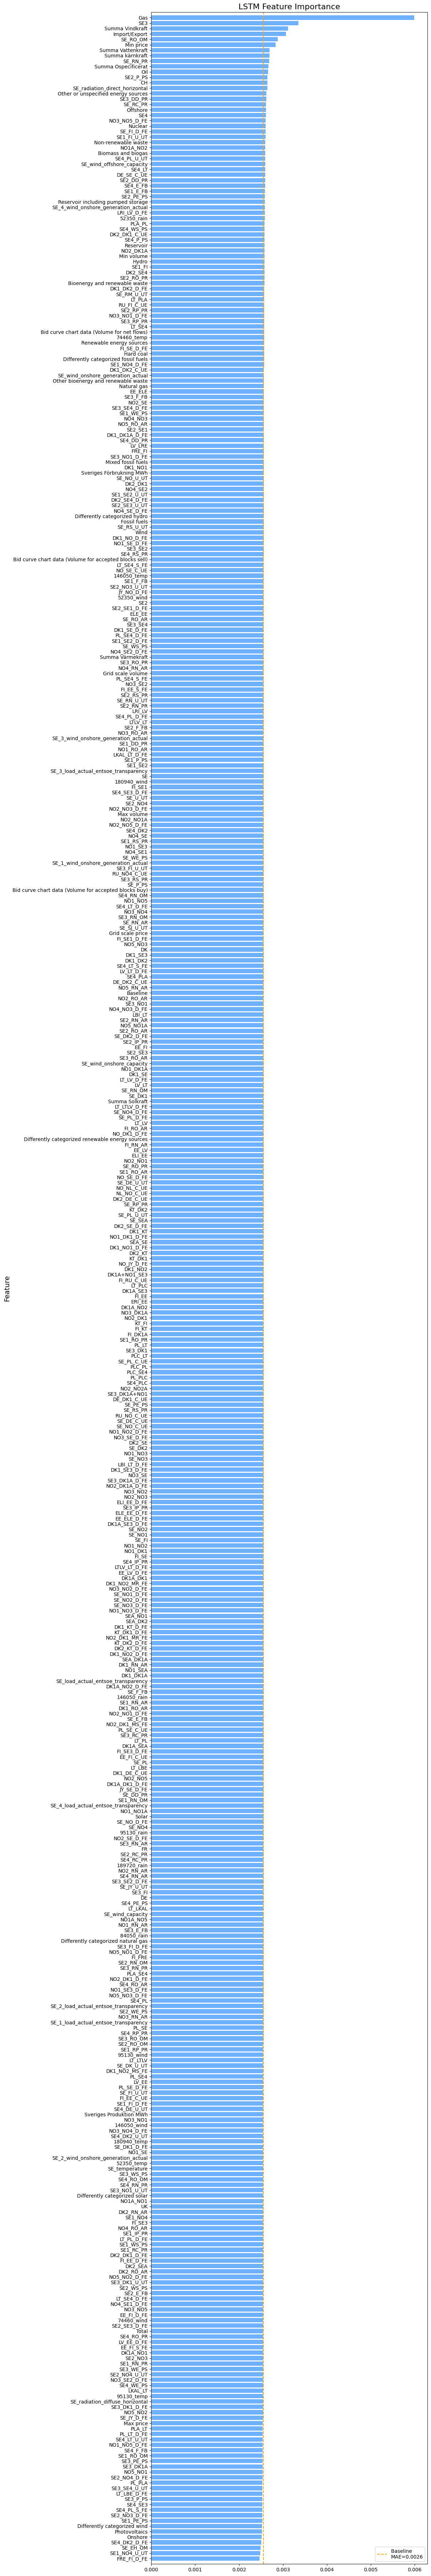

([], [], [])

In [23]:
feature_cutoff(df, baseline_mae, n_cols, 'baseline', cutoff = 0, prime = 0)

# Iteration 1

Remove unused memory allocations

In [36]:
import gc
gc.collect()

26743

## Feature Importance cutoff

469
(470,)


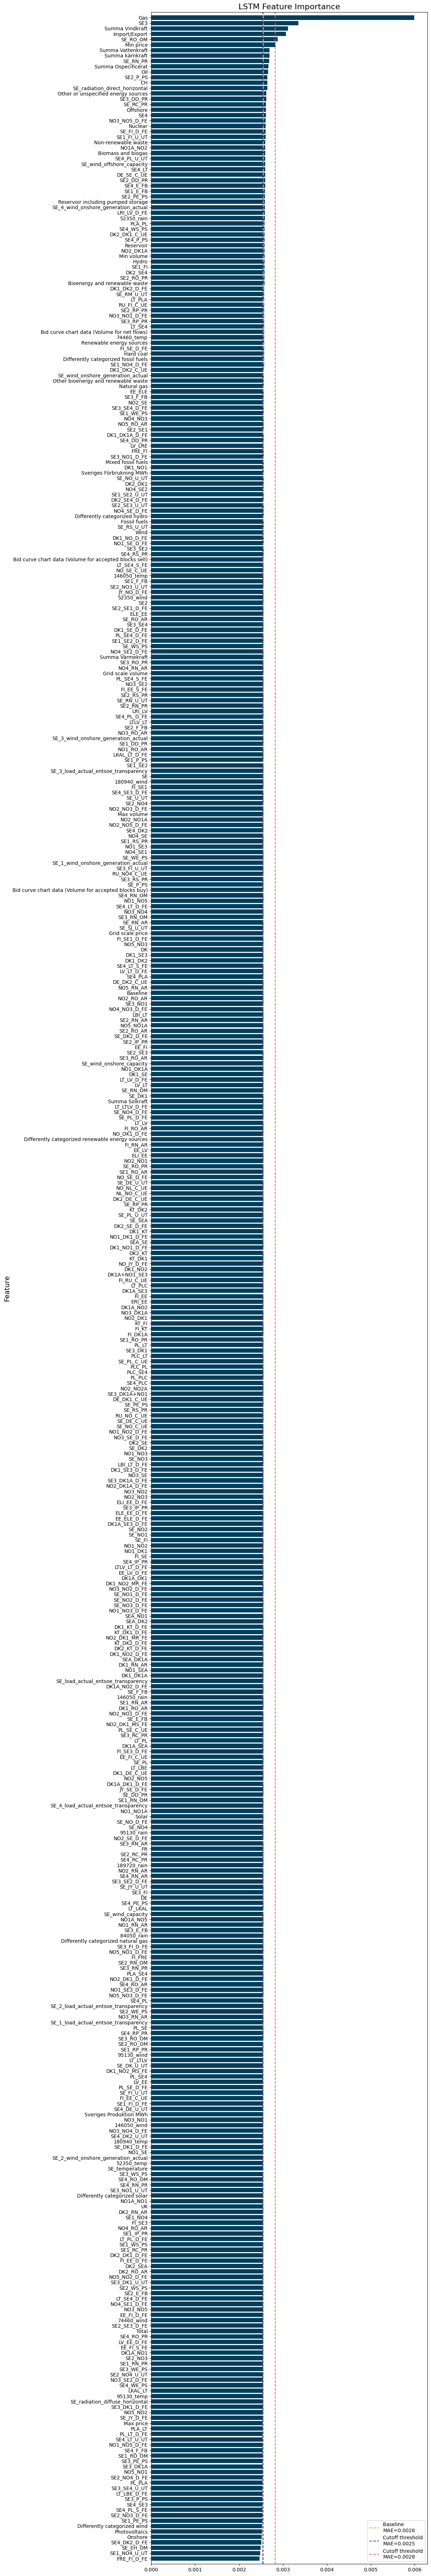

In [150]:
a_set_columns, b_set_columns, prime_set_columns = feature_cutoff(df, baseline_mae, n_cols, 'baseline', cutoff = 1, prime = 1)

### B set

Data shape: 
(202878, 26)
Average amount of unique values per feature:
0    2779.115385
dtype: float64
Average percentage of unique values per feature:
0    0.013698
dtype: float64


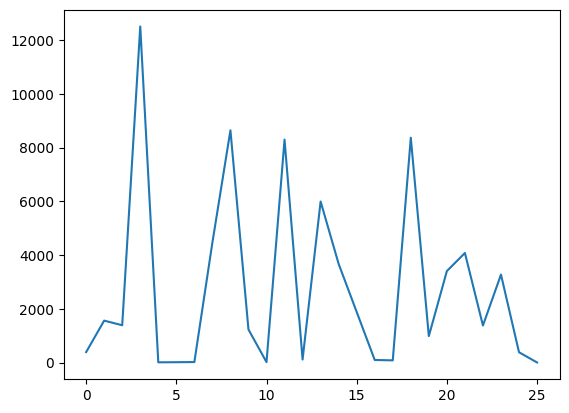

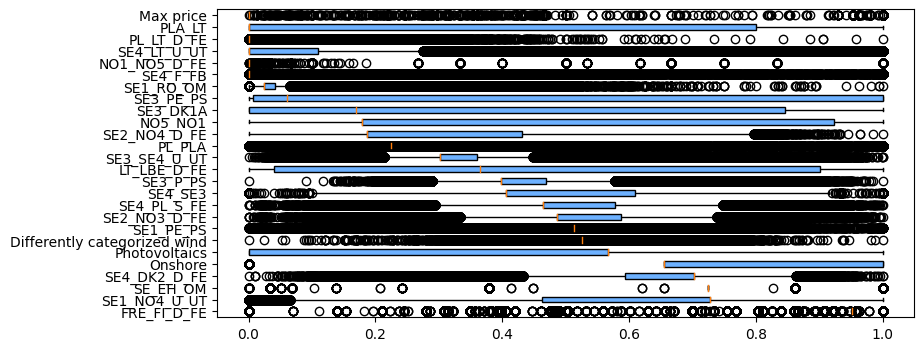

In [25]:
b_set = df[b_set_columns]
run_analysis_suite(b_set, b_set_columns)

### A set

Data shape: 
(202878, 443)
Average amount of unique values per feature:
0    9175.936795
dtype: float64
Average percentage of unique values per feature:
0    0.045229
dtype: float64


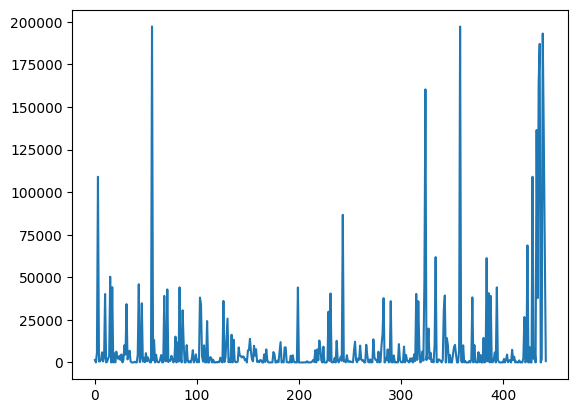

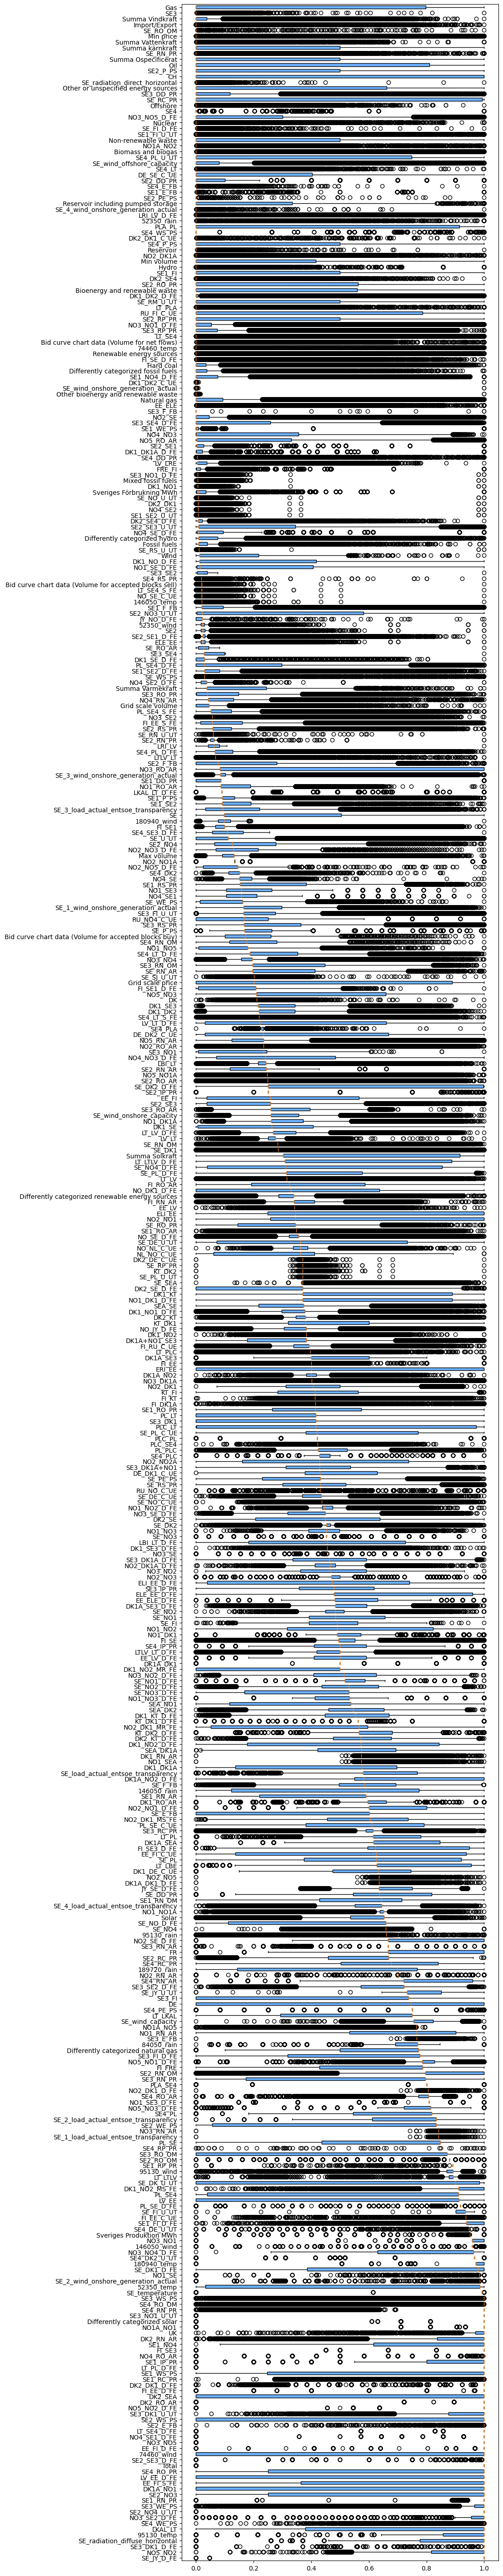

In [26]:
a_set = df[a_set_columns]
run_analysis_suite(a_set, a_set_columns)

### Prime

No handles with labels found to put in legend.


Data shape: 
(202878, 6)
Average amount of unique values per feature:
0    66081.333333
dtype: float64
Average percentage of unique values per feature:
0    0.32572
dtype: float64


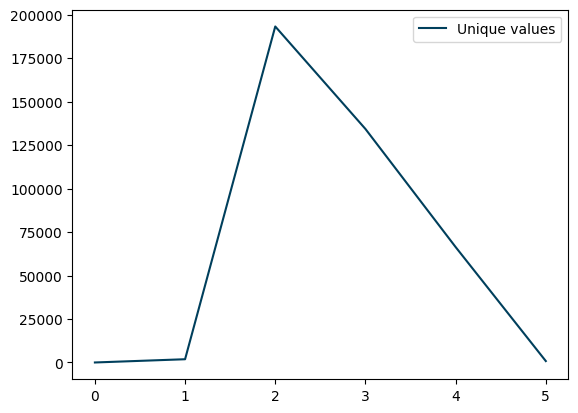

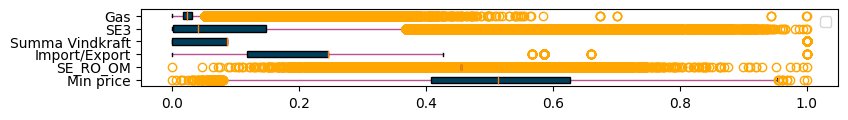

In [146]:
prime_set = df[prime_set_columns]
run_analysis_suite(prime_set, prime_set_columns)

## Time slice selection

Dispose of unused memory

In [41]:
gc.collect()

16

1347
0.0031819809996246643


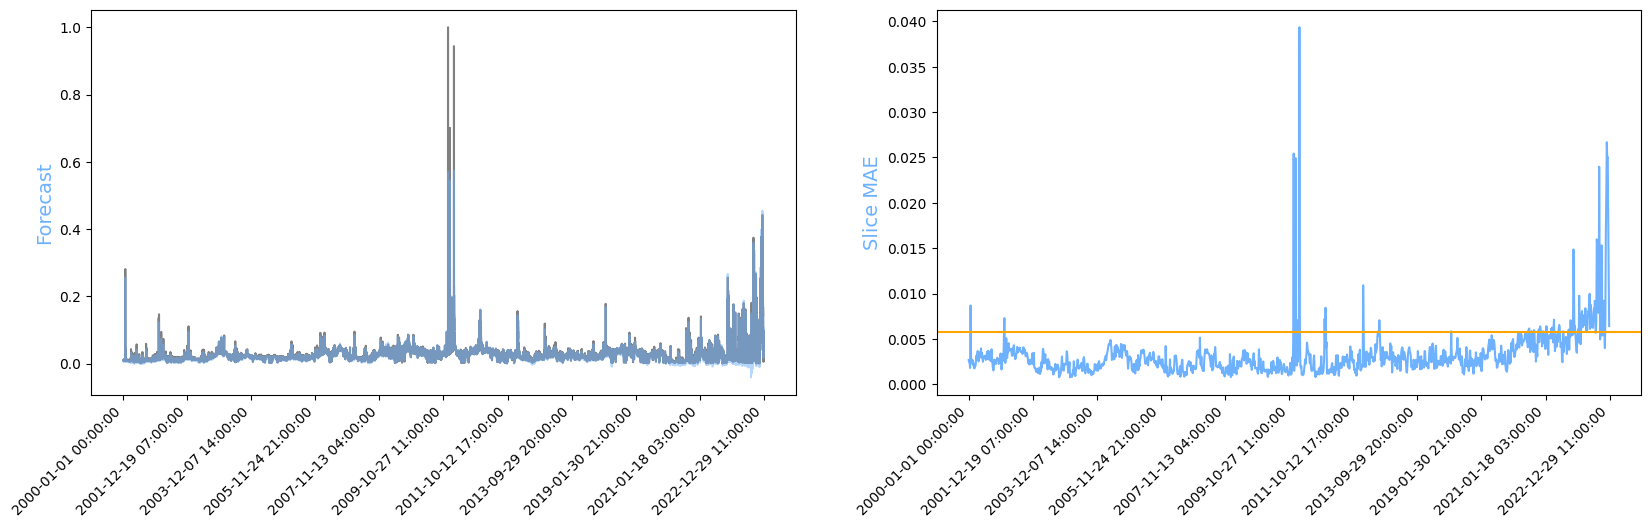

In [46]:
train_interesting_batch_indices, train_preds = time_slice_mae_plot(model, X_train, y_train, batch_size, train_dates)

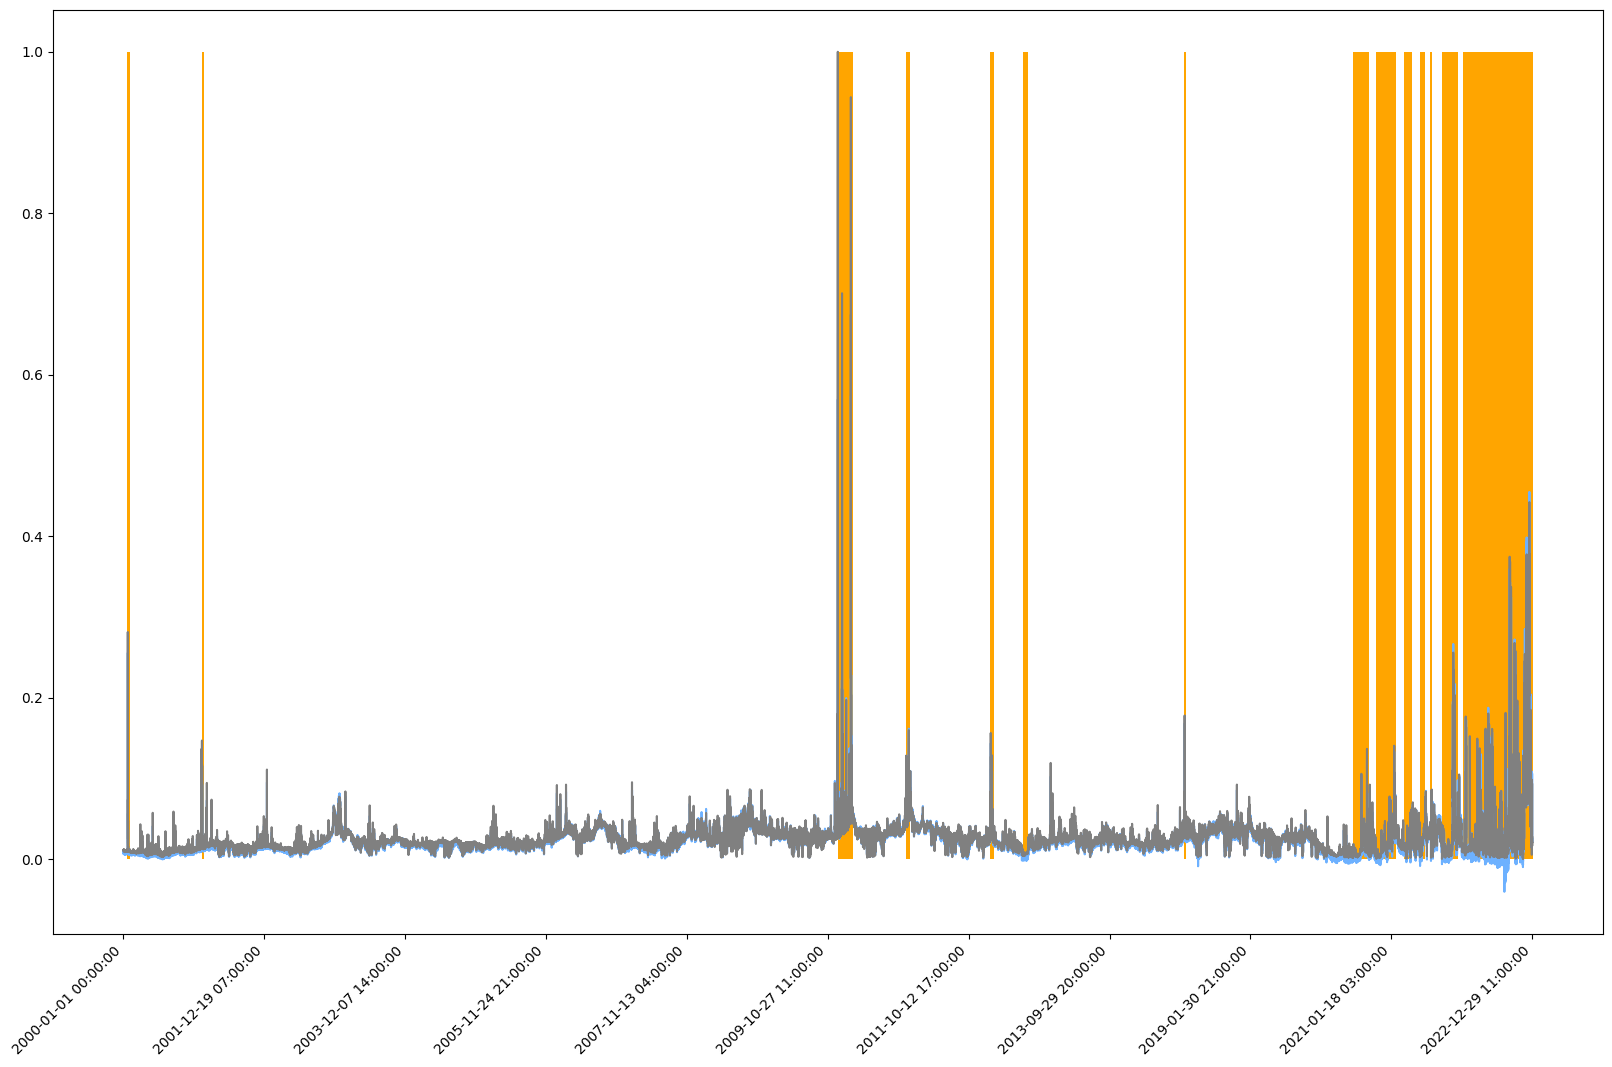

In [30]:
train_slices = getSlices(X_train, y_train, train_interesting_batch_indices, batch_size, train_preds, train_dates)

In [60]:
printSliceMae(train_slices, X_train, y_train, model, batch_size)

steps in slice:  128     mae 0.02340975753677812
steps in slice:  128     mae 0.01656071043961469
steps in slice:  1792     mae 0.03263042560804786
steps in slice:  384     mae 0.020814656974655996
steps in slice:  256     mae 0.020287444776840323
steps in slice:  512     mae 0.005835537572468825
steps in slice:  128     mae 0.018607714441381117
steps in slice:  1792     mae 0.011997257594139811
steps in slice:  2304     mae 0.016485466690942016
steps in slice:  896     mae 0.008493947177881643
steps in slice:  384     mae 0.007158965225347078
steps in slice:  128     mae 0.006372409618030917
steps in slice:  1792     mae 0.03495500459608337
steps in slice:  8448     mae 0.05576257309377393


158


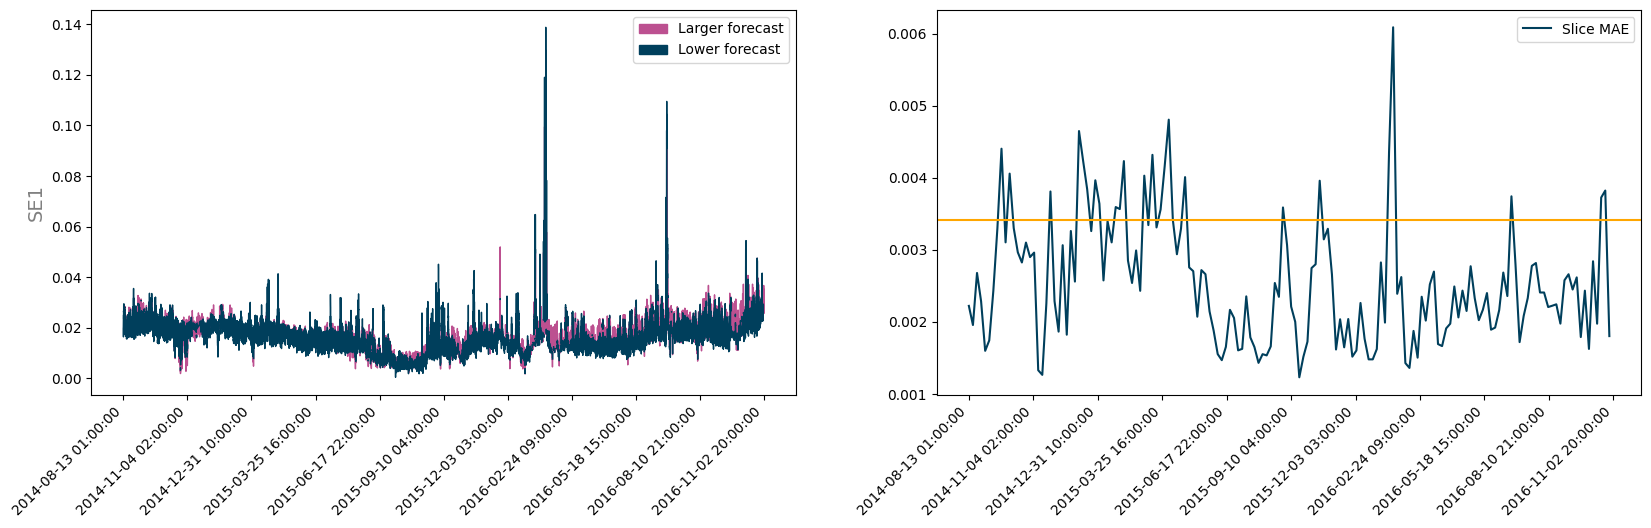

In [130]:
val_interesting_batch_indices, val_preds = time_slice_mae_plot(model, X_val, y_val, batch_size, val_dates)

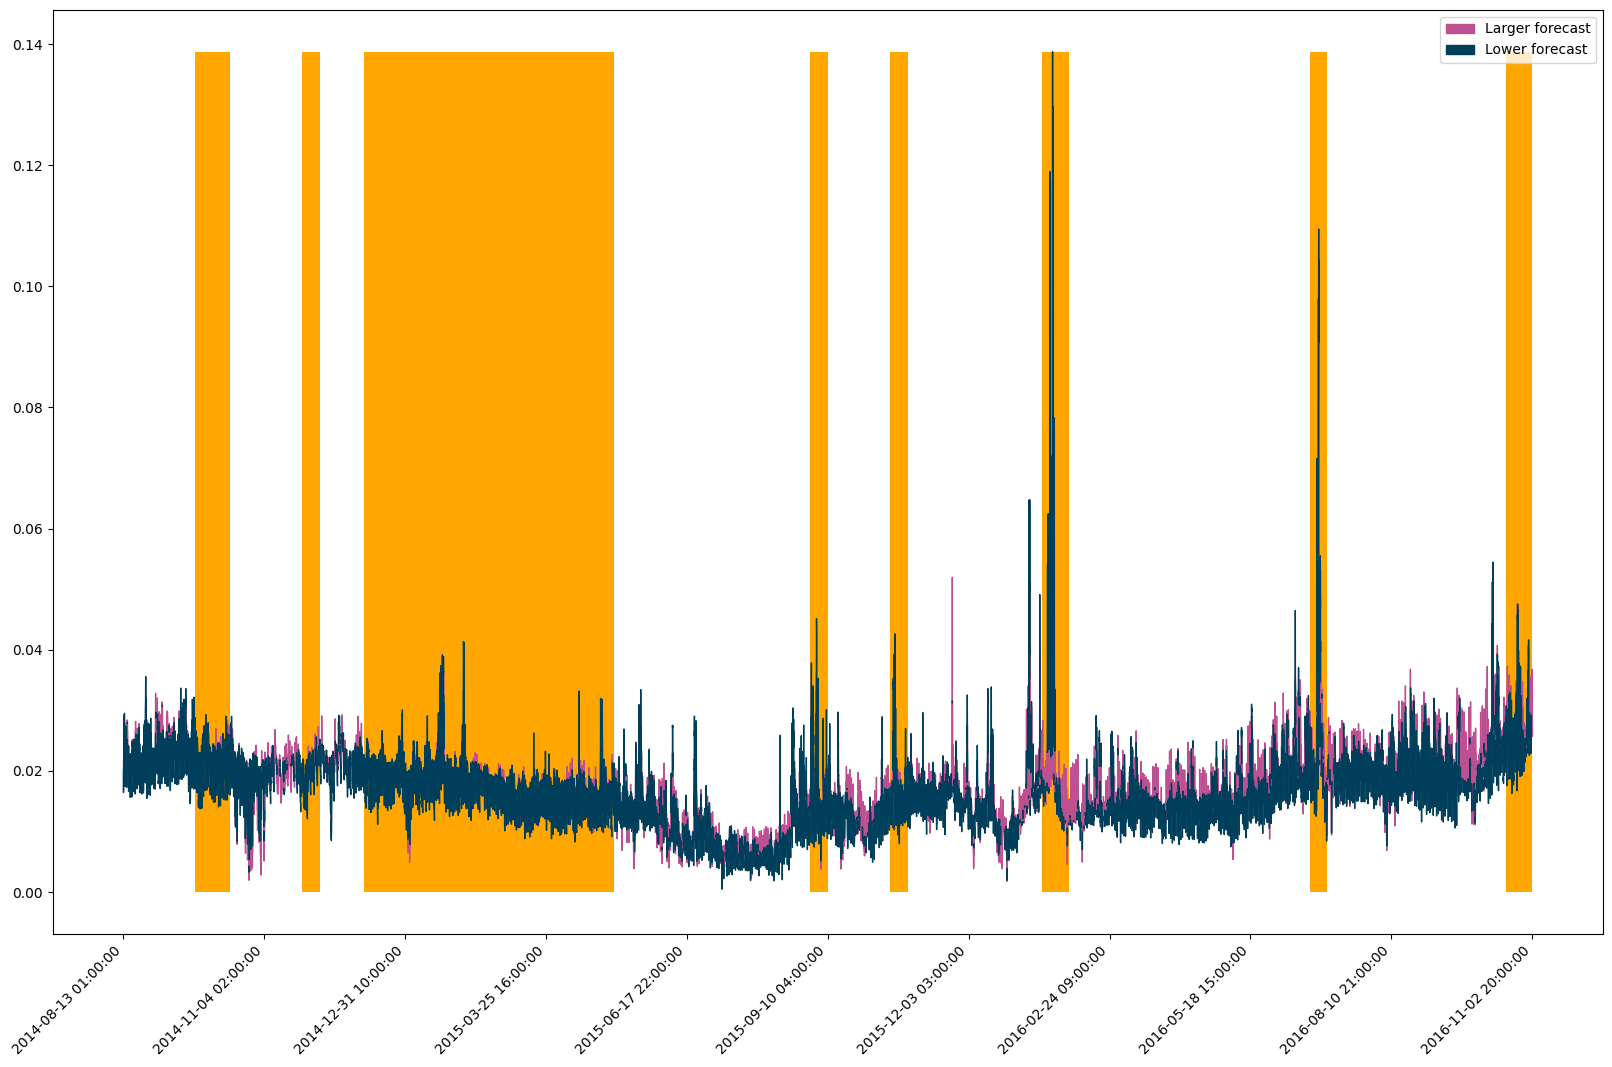

In [121]:
val_slices = getSlices(X_val, y_val, val_interesting_batch_indices, batch_size, val_preds, val_dates)

In [59]:
printSliceMae(val_slices, X_val, y_val, model, batch_size)

steps in slice:  384     mae 0.004336096990556083
steps in slice:  128     mae 0.004129803464674326
steps in slice:  3456     mae 0.004472413544146723
steps in slice:  128     mae 0.008473052374067163
steps in slice:  128     mae 0.006193671348751466
steps in slice:  256     mae 0.01582210728015772
steps in slice:  128     mae 0.008431027429164902
steps in slice:  256     mae 0.006094167593807764
